In [12]:
# Import packages
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import seaborn as sns

from tqdm import tqdm

# Import DQN and DDPG
from dql import DQAgent, DQN
from ddpg import DDPGAgent

import warnings
warnings.filterwarnings("ignore")
from torch import multiprocessing

from collections import defaultdict

from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,
                          TransformedEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

# Define agents  

In [13]:
# Set up files directory and environment
save_dir = 'models'
save_name = 'DQL'
path = os.path.join(save_dir, f'{save_name}_final.pt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DQN and DDPG
env = gym.make("InvertedDoublePendulum-v4", render_mode="rgb_array")

# PPO
base_env = GymEnv("InvertedDoublePendulum-v4", device=device)
env_ppo = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(),
        StepCounter(),
    ),
)
env_ppo.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)
num_cells = 256

In [14]:
# Not important for testing
epsilon_min=0.01,
epsilon_decay=0.00015,
memory_size=100_000

# Parameters
testing_episodes = 1000

batch_size = 32
gamma = 0.99
learning_rate = 0.0005
tau = 0.005
exploration_sd = 0.05

malfunction_probability = 0

In [15]:
# Parameters
state_size = env.observation_space.shape[0]  
activation_function = 'tanh'
action_size = 11

n_episodes = 1000  # Number of testing episodes

In [16]:
# initialize neural network and load state
loaded_model = DQN(state_size, action_size, activation_function='tanh')
loaded_model.load_state_dict(torch.load(path))
loaded_model.to(device) 

# Initialize agent 
agent = DQAgent(state_size=state_size,
                action_size=action_size,
                epsilon_min=epsilon_min,
                epsilon_decay=epsilon_decay,
                memory_size=memory_size,
                activation_function=activation_function)
# Add loaded model to agent
agent.model = loaded_model
agent.target_model = loaded_model
# Initialize agent's epsilon
agent.epsilon = 0.1

In [17]:
actor_net_ppo = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env_ppo.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

policy_module_ppo = TensorDictModule(
    actor_net_ppo, in_keys=["observation"], out_keys=["loc", "scale"]
)

policy_module_ppo = ProbabilisticActor(
    module=policy_module_ppo,
    spec=env_ppo.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env_ppo.action_spec.space.low,
        "max": env_ppo.action_spec.space.high,
    },
    return_log_prob=True,
    
)

In [18]:
policy_module_ppo.load_state_dict(torch.load("models\\ppo_policy.pth"))

<All keys matched successfully>

In [19]:
agent_ddpg = DDPGAgent(state_size=state_size,
                       gamma=gamma,
                       learning_rate=learning_rate,
                       tau=tau,
                       exploration_sd=exploration_sd,
                       memory_size=memory_size)

actor_filepath = os.path.join('models', f'DDPG_final_actor.pt')
critic_filepath = os.path.join('models', f'DDPG_final_critic.pt')
agent_ddpg.load_networks(actor_filepath, critic_filepath)

# Test

In [9]:
returns_dql = []
steps_dql = []
returns_ppo = []
steps_ppo = []
returns_ddpg = []
steps_ddpg = []

for _ in tqdm(range(n_episodes)):
    # DQL
    episode_return, episode_steps = agent.generate_greedy_episode(env, render=False)
    # PPO
    eval_rollout = env_ppo.rollout(1000, policy_module_ppo)
    # DDPG
    episode_return_ddpg, episode_steps_ddpg = agent_ddpg.generate_greedy_episode(env, malfunction_probability=malfunction_probability)
    returns_dql.append(episode_return)
    steps_dql.append(episode_steps)
    returns_ppo.append(eval_rollout["next", "reward"].sum().item())
    steps_ppo.append(eval_rollout["step_count"].sum().item())
    returns_ddpg.append(episode_return_ddpg)
    steps_ddpg.append(episode_steps_ddpg)

100%|██████████| 1000/1000 [14:31<00:00,  1.15it/s]


In [10]:
print(f'Correlation between steps and returns - dqn = {np.corrcoef(returns_dql, steps_dql)[0, 1]}')
print(f'Correlation between steps and returns - ppo = {np.corrcoef(returns_ppo, steps_ppo)[0, 1]}')
print(f'Correlation between steps and returns - ddpg = {np.corrcoef(returns_ddpg, steps_ddpg)[0, 1]}')

Correlation between steps and returns - dqn = 0.999989511031602
Correlation between steps and returns - ppo = 0.9938628253997148
Correlation between steps and returns - ddpg = nan


As the correlation is very high, we will focus only on steps and won't look at the returns.

# Plotting

C:\Users\lucat\Documents\GitHub\DLA\venv\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


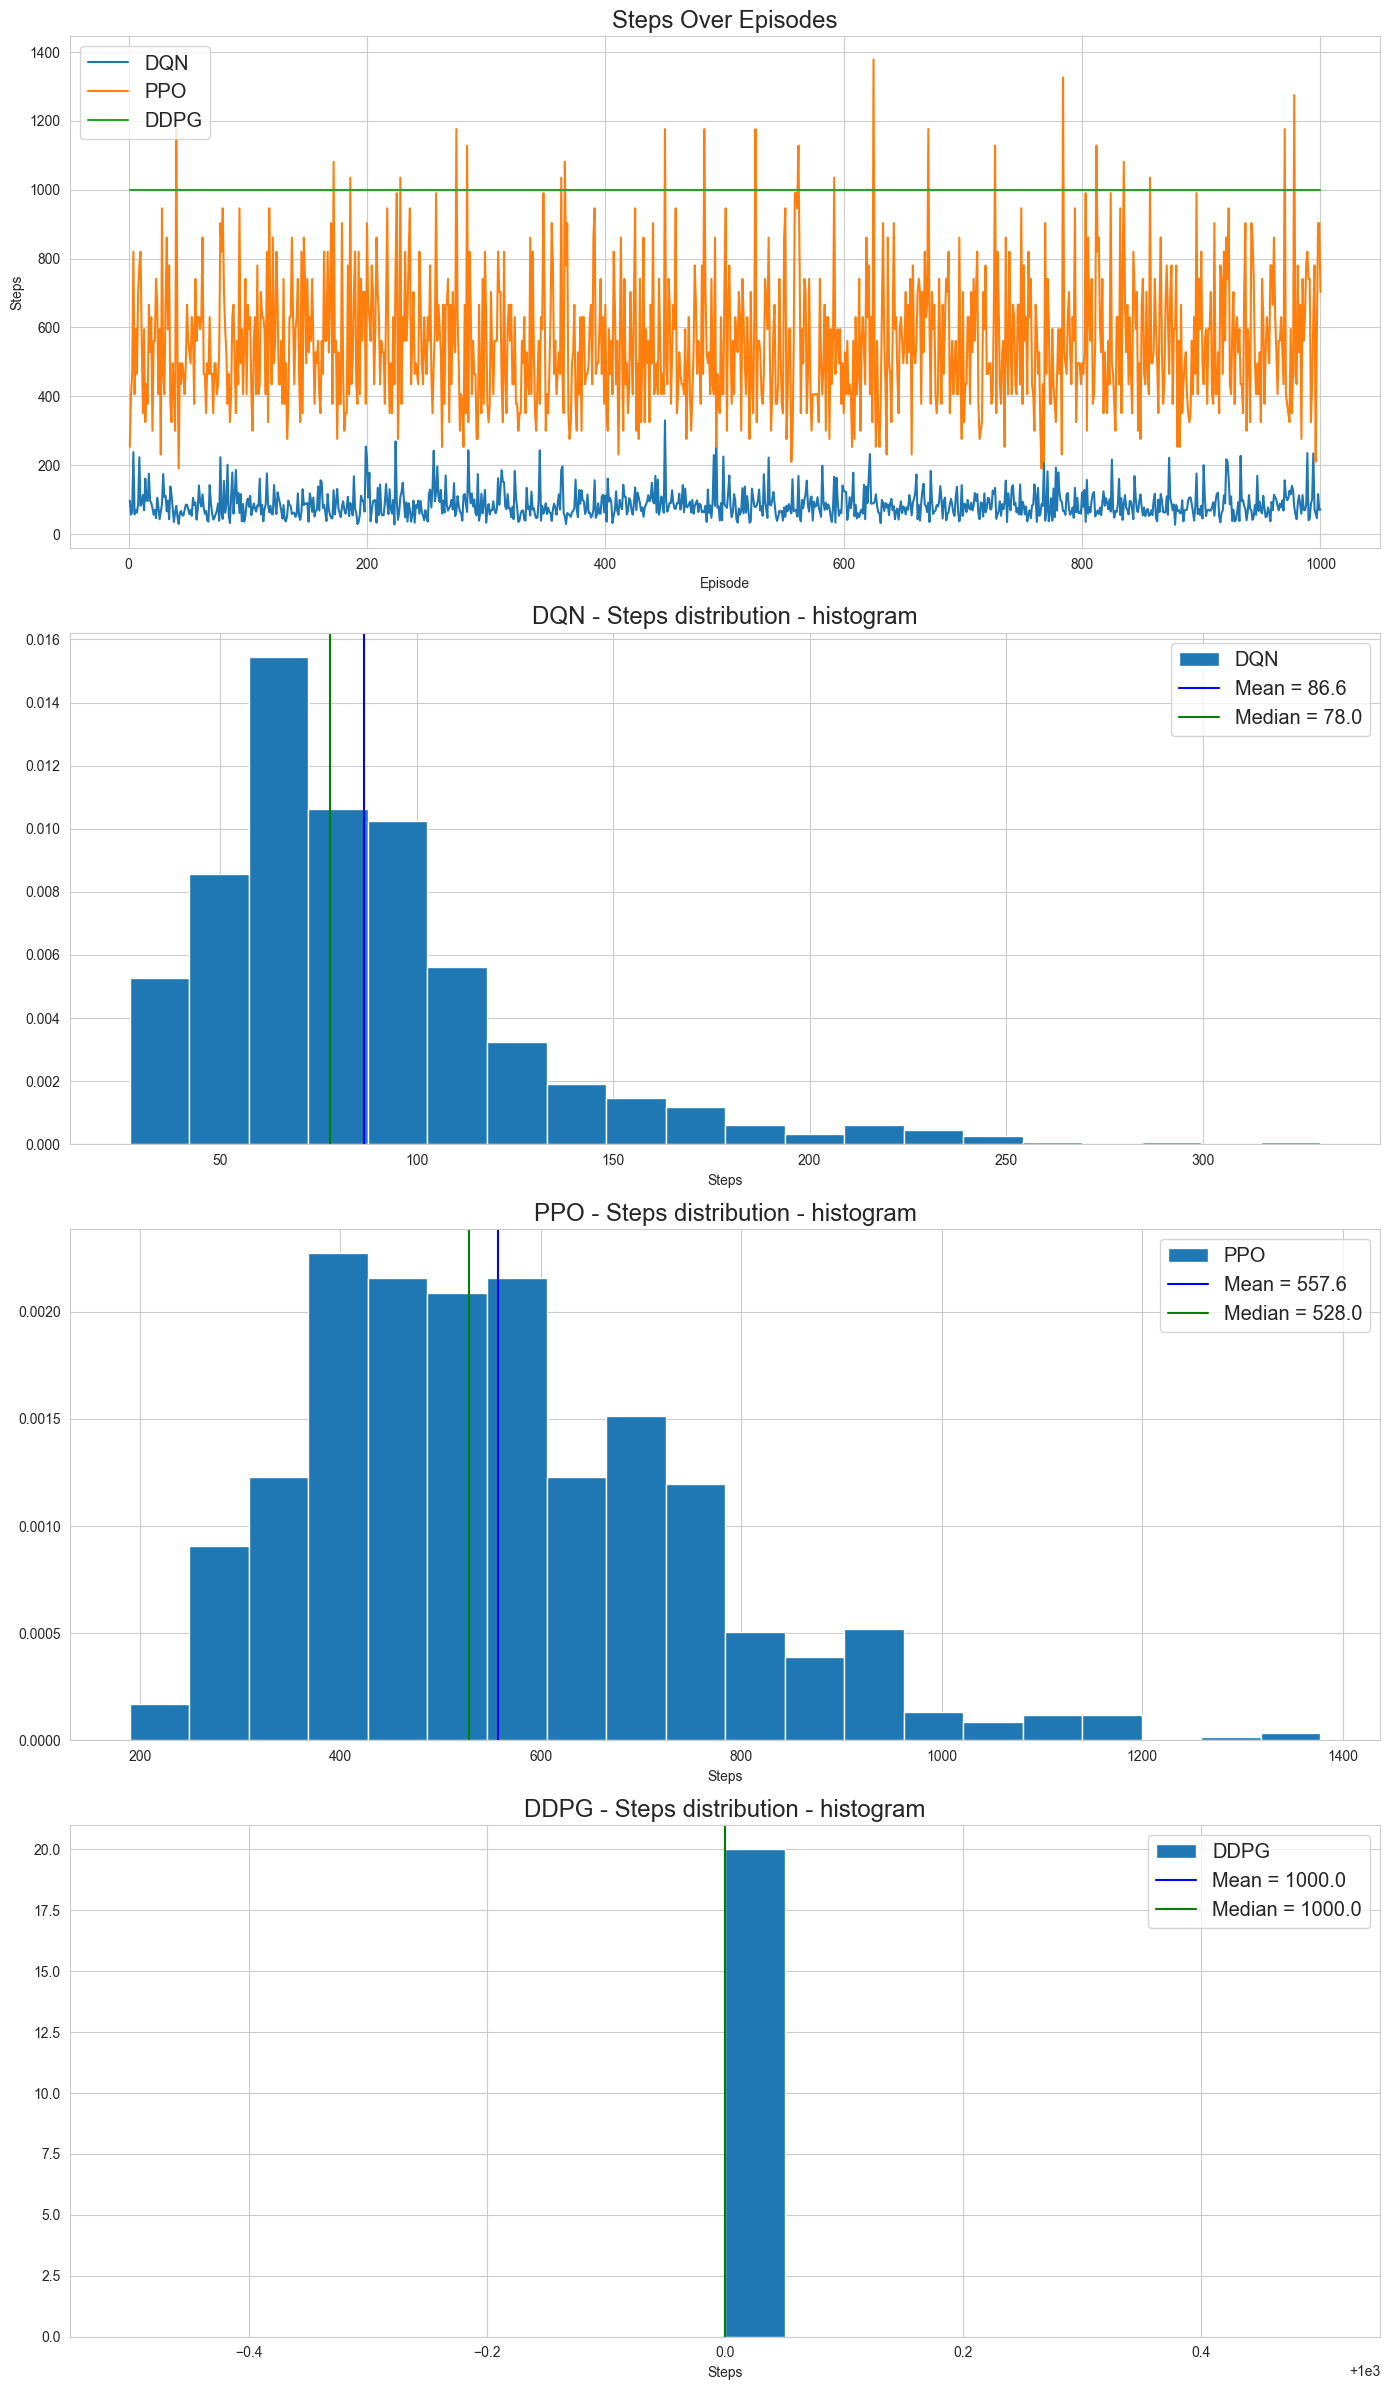

In [11]:
#plt.style.use('ggplot')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 24), tight_layout=True)
#pd.set_option('mode.use_inf_as_null', True)

# Plot 1
ax1.plot(range(1, n_episodes + 1), steps_dql, label='DQN')
ax1.plot(range(1, n_episodes + 1), steps_ppo, label='PPO')
ax1.plot(range(1, n_episodes + 1), steps_ddpg, label='DDPG')
ax1.set_title('Steps Over Episodes', fontsize='xx-large')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Steps')
ax1.legend(fontsize='x-large')

# Plot 2
ax2.hist(steps_dql, density=True, stacked=True, label='DQN', bins=20)
ax2.set_title('DQN - Steps distribution - histogram', fontsize='xx-large')
ax2.set_xlabel('Steps')
ax2.axvline(x=np.mean(steps_dql), color='blue', label=f'Mean = {np.mean(steps_dql):.1f}')
ax2.axvline(x=np.median(steps_dql), color='green', label=f'Median = {np.median(steps_dql):.1f}')
ax2.legend(fontsize='x-large')

# Plot 3
ax3.hist(steps_ppo, density=True, stacked=True, label='PPO', bins=20)
ax3.set_title('PPO - Steps distribution - histogram', fontsize='xx-large')
ax3.set_xlabel('Steps')
ax3.axvline(x=np.mean(steps_ppo), color='blue', label=f'Mean = {np.mean(steps_ppo):.1f}')
ax3.axvline(x=np.median(steps_ppo), color='green', label=f'Median = {np.median(steps_ppo):.1f}')
ax3.legend(fontsize='x-large')

# Plot 4
ax4.hist(steps_ddpg, density=True, stacked=True, label='DDPG', bins=20)
ax4.set_title('DDPG - Steps distribution - histogram', fontsize='xx-large')
ax4.set_xlabel('Steps')
ax4.axvline(x=np.mean(steps_ddpg), color='blue', label=f'Mean = {np.mean(steps_ddpg):.1f}')
ax4.axvline(x=np.median(steps_ddpg), color='green', label=f'Median = {np.median(steps_ddpg):.1f}')
ax4.legend(fontsize='x-large')

plt.show()

The best seems to be **DDPG** model.

# Graphical Visualization - DDPG

In [20]:
# Malfunction probability = 0%
plt.style.use('default')

checkpoint = 'final'
actor_filepath = os.path.join('models', f'DDPG_{checkpoint}_actor.pt')
critic_filepath = os.path.join('models', f'DDPG_{checkpoint}_critic.pt')
agent_ddpg.load_networks(actor_filepath, critic_filepath)

malfunction_probability = 0.01

_, _ = agent_ddpg.generate_greedy_episode(env, render=True, frame_rate=1/30, malfunction_probability=malfunction_probability)

KeyboardInterrupt: 

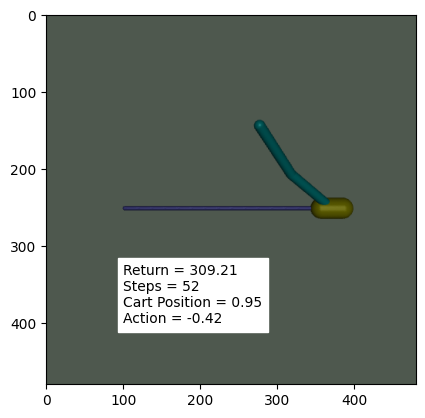

In [23]:
# Malfunction probability = 1%
malfunction_probability = 0.01
_, _ = agent_ddpg.generate_greedy_episode(env, render=True, frame_rate=1/30, malfunction_probability=malfunction_probability)